# Generating Weekday and Weekend profiles

In [ ]:
import polars as pl
import glob
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import logging
from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True

from validation import validation

## Weekend profiles

In [39]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_cleaned")
output_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_weekend_normalized")
output_folder.mkdir(parents=True, exist_ok=True)

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

def day_avg_preprocess_weekend(df):
    # Parse the timestamp column (assuming 'zeitpunkt' column exists)
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    
    # Filter only Saturdays (weekday 5) and Sundays (weekday 6)
    df = df.filter(pl.col("zeitpunkt_dt").dt.weekday().is_in([6, 7]))
    
    # Extract time_of_day (hour, minute) as time component
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.time().alias("time_of_day")
    )
    
    # Group by time_of_day across all weekend days and average the energy column
    day_avg = (
        df.group_by("time_of_day")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("time_of_day")
    )
    return day_avg

def normalize(df):
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )
    
    return df

for file_path in file_paths:
    df = pl.read_csv(file_path)
    day_avg = day_avg_preprocess_weekend(df)
    day_avg = normalize(day_avg)
    
    filename = os.path.basename(file_path)  # Original file name
    output_file = output_folder / filename  # Output path with same filename
    
    day_avg.write_csv(output_file)


    

## Weekday profiles

In [37]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_cleaned")
output_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_weekday_normalized")
output_folder.mkdir(parents=True, exist_ok=True)

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

def day_avg_preprocess_weekday(df):
    # Parse the timestamp column (assuming 'zeitpunkt' column exists)
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    
    # Filter only Saturdays (weekday 5) and Sundays (weekday 6)
    #df = df.filter(pl.col("zeitpunkt_dt").dt.weekday().is_in([1,2,3,4,5,6,7]))
    
    # Extract time_of_day (hour, minute) as time component
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.time().alias("time_of_day")
    )
    
    # Group by time_of_day across all weekend days and average the energy column
    day_avg = (
        df.group_by("time_of_day")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("time_of_day")
    )
    return day_avg

def normalize(df):
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )
    
    return df

for file_path in file_paths:
    df = pl.read_csv(file_path)
    day_avg = day_avg_preprocess_weekday(df)
    day_avg = normalize(day_avg)
    
    filename = os.path.basename(file_path)  # Original file name
    output_file = output_folder / filename  # Output path with same filename
    
    day_avg.write_csv(output_file)

## Weekday Clustering-->Difference between weekday and weekend

In [40]:
#input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_weekday_normalized")
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_weekday_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)

data_3d = np.concatenate(data_list, axis=0)
print(f"Shape of the 3D array: {data_3d.shape}")

train_data = data_3d

Shape of the 3D array: (1464, 96, 1)


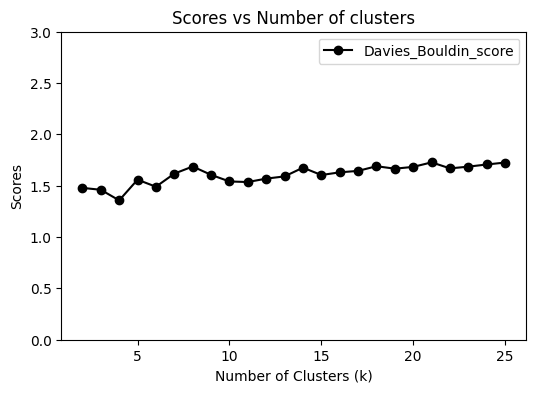

In [41]:
validation(data_3d)

In [42]:
n_clusters = 7  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

2.761 --> 1.831 --> 1.766 --> 1.748 --> 1.742 --> 1.738 --> 1.736 --> 1.735 --> 1.734 --> 1.733 --> 1.732 --> 1.732 --> 1.732 --> 1.731 --> 1.731 --> 1.731 --> 1.731 --> 1.731 --> 1.731 --> 1.730 --> 1.730 --> 1.730 --> 1.730 --> 1.730 --> 1.730 --> 1.729 --> 1.729 --> 1.729 --> 1.729 --> 1.729 --> 1.729 --> 1.729 --> 1.729 --> 


In [43]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['black','blue','red','maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','magenta','pink','violet']

def plot_clusters_season():
    
    plt.figure(figsize=(8,6))
    for cluster_idx in range(n_clusters):
        # Get all time series in this cluster
        cluster_data = train_data[clusters_train == cluster_idx]
        cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
        # Calculate the mean time series for the cluster
        mean_time_series = np.mean(cluster_data, axis=0)
    
        # Plot the mean time series
        cluster_no = cluster_idx+1
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'{cluster_no} Number of Time Series: {len(cluster_indices)}',
                linewidth =2, color=colors[cluster_idx] )
    plt.title("daily_profiles")
    plt.xlabel("Time")
    plt.ylabel(" Normalized Energy Consumption")
    plt.ylim(0,1)
    #plt.xticks(range(1,108,12),labels=labels)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend()
    #plt.margins(0)
    plt.grid(True, color = 'lightgray')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

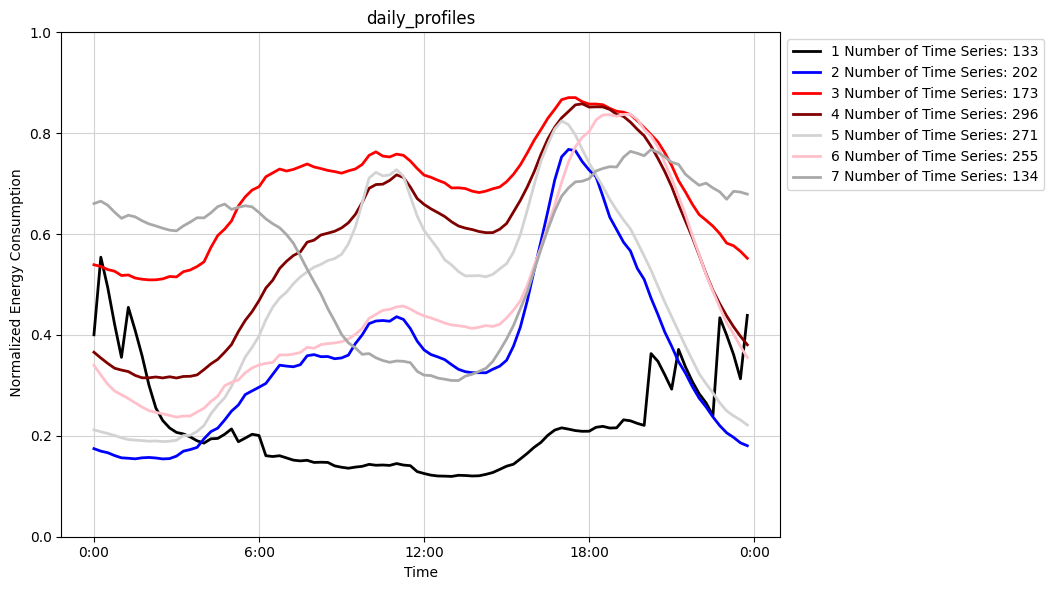

In [44]:
plot_clusters_season()

Shape of the 3D array: (1464, 96, 1)


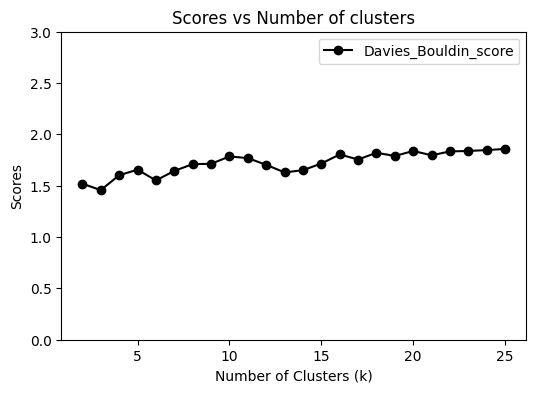

In [45]:
pattern = f"{r'DATA/SM_DATA_weekend_normalized'}/*CH*.csv"
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)

data_3d = np.concatenate(data_list, axis=0)
print(f"Shape of the 3D array: {data_3d.shape}")

train_data = data_3d

validation(data_3d)



In [46]:
n_clusters = 4  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

3.943 --> 2.439 --> 2.317 --> 2.278 --> 2.260 --> 2.252 --> 2.250 --> 2.249 --> 2.249 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 


In [47]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['black','blue','red','maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','magenta','pink','violet']

def plot_clusters_season():
    
    plt.figure(figsize=(8,6))
    for cluster_idx in range(n_clusters):
        # Get all time series in this cluster
        cluster_data = train_data[clusters_train == cluster_idx]
        cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
        # Calculate the mean time series for the cluster
        mean_time_series = np.mean(cluster_data, axis=0)
    
        # Plot the mean time series
        cluster_no = cluster_idx+1
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'{cluster_no} Number of Time Series: {len(cluster_indices)}',
                linewidth =2, color=colors[cluster_idx] )
    plt.title("daily_profiles")
    plt.xlabel("Time")
    plt.ylabel(" Normalized Energy Consumption")
    plt.ylim(0,1)
    #plt.xticks(range(1,108,12),labels=labels)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend()
    #plt.margins(0)
    plt.grid(True, color = 'lightgray')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

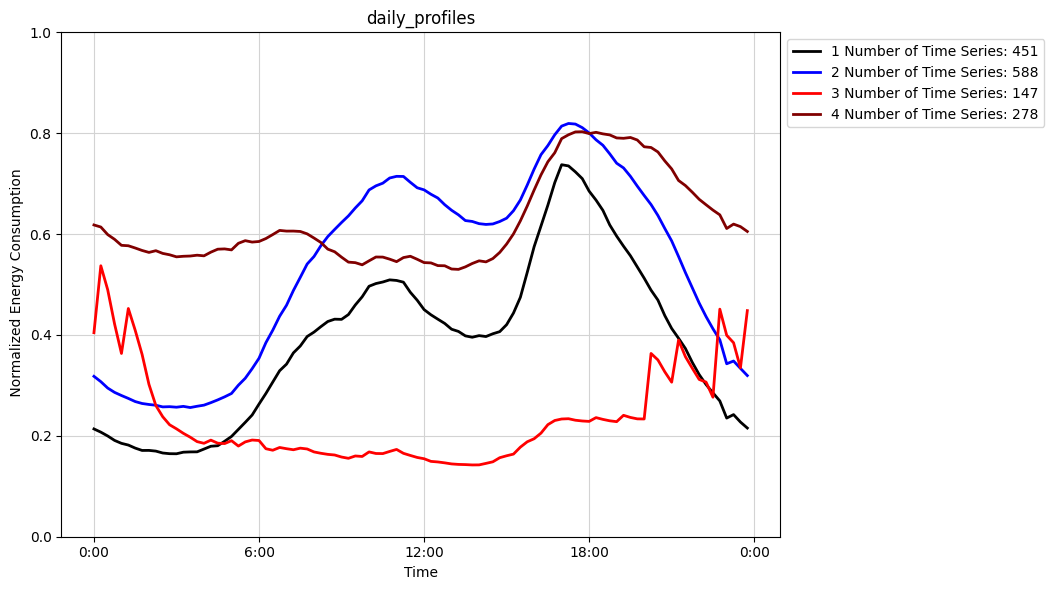

In [48]:
plot_clusters_season()